In [14]:
#import yfinance as yf
#import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt
#from arch import arch_model
#from statsmodels.graphics.tsaplots import plot_acf
#from statsmodels.tsa.stattools import adfuller

# Fetch CAG data
#cag_data = yf.download('CAG', start='2015-01-01', end='2024-12-31')






In [15]:
#cag = cag_data.copy()
#cag = cag.reset_index(drop=False)
#cag.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
#cag= cag.set_index('Date')

#cag = cag['Close']

#cag.to_csv('CAG_2015_2024.csv')

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

cag = pd.read_csv('CAG_2015_2024.csv', parse_dates=True, index_col=0)
cag['Close'] = pd.to_numeric(cag['Close'], errors='coerce')
cag.head()

,Close
Date,
2015-01-02,20.157829
2015-01-05,19.938356
2015-01-06,19.741388
2015-01-07,20.208479
2015-01-08,20.647425


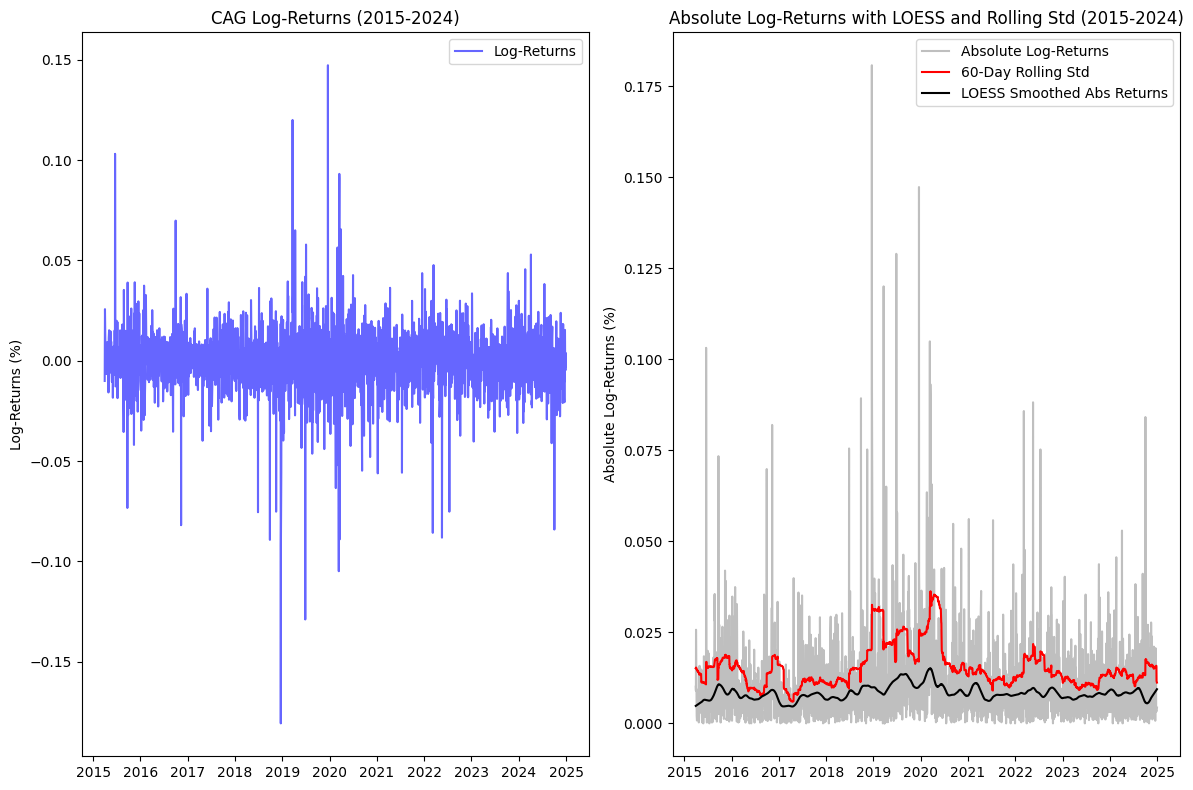

In [19]:
import statsmodels.api as sm


# Calculate log-returns
cag['Log_Return'] = np.log(cag['Close'] / cag['Close'].shift(1)).dropna()

# Compute absolute log-returns
cag['Abs_Log_Return'] = np.abs(cag['Log_Return'])

# Compute rolling 60-day standard deviation
cag['Rolling_Std'] = cag['Log_Return'].rolling(window=60).std()

cag.dropna(inplace=True)

# LOESS smoothing (LOWESS from statsmodels)
lowess = sm.nonparametric.lowess
smoothed_abs = lowess(cag['Abs_Log_Return'], cag.index, frac=0.03)


# Plot time series
fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharex=True)

# Plot log-returns
top_ax = axes[0]
top_ax.plot(cag.index, cag['Log_Return'], color='blue', alpha=0.6, label='Log-Returns')
top_ax.set_ylabel("Log-Returns (%)")
top_ax.set_title("CAG Log-Returns (2015-2024)")
top_ax.legend()

# Plot absolute log-returns with LOESS and rolling std
bottom_ax = axes[1]
bottom_ax.plot(cag.index, cag['Abs_Log_Return'], color='gray', alpha=0.5, label='Absolute Log-Returns')
bottom_ax.plot(cag.index, cag['Rolling_Std'], color='red', label='60-Day Rolling Std')
bottom_ax.plot(cag.index, smoothed_abs[:, 1], color='black', label='LOESS Smoothed Abs Returns')
bottom_ax.set_ylabel("Absolute Log-Returns (%)")
bottom_ax.set_title("Absolute Log-Returns with LOESS and Rolling Std (2015-2024)")
bottom_ax.legend()

plt.tight_layout()
plt.show()

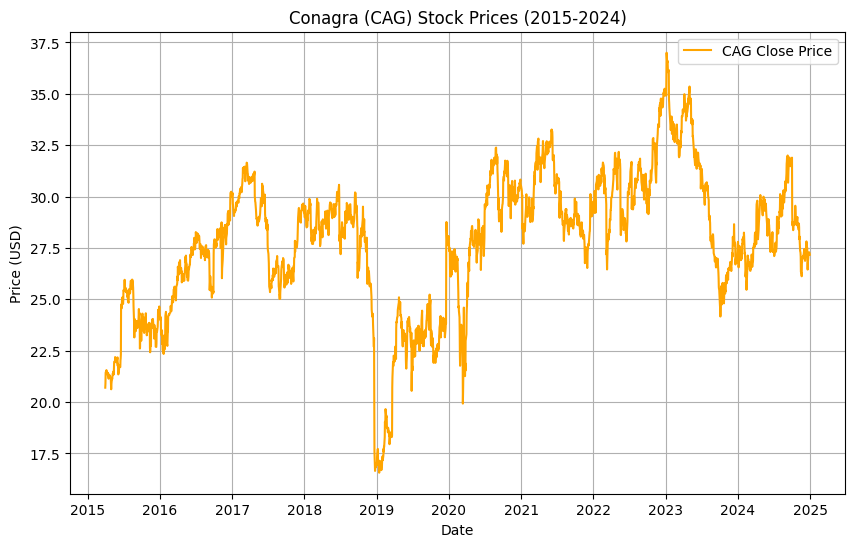

In [20]:


plt.figure(figsize=(10, 6))
plt.plot(cag['Close'], label='CAG Close Price', color='orange')
plt.title('Conagra (CAG) Stock Prices (2015-2024)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

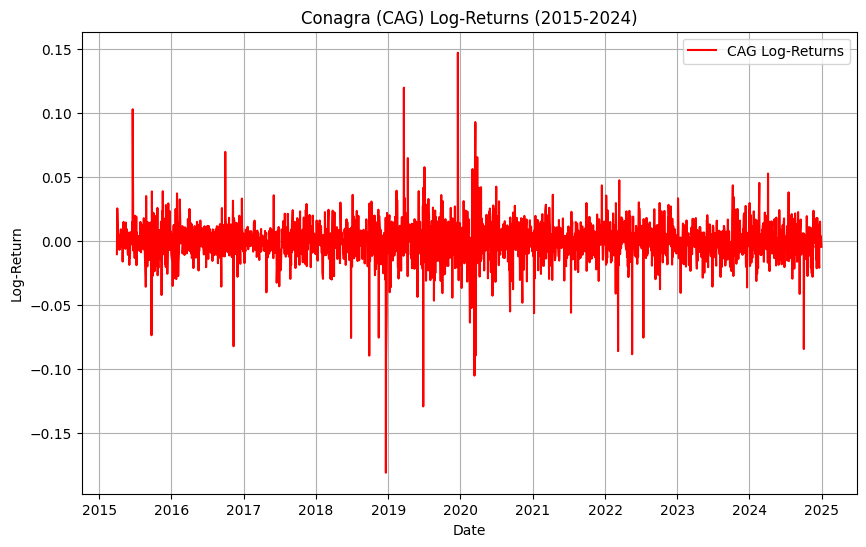

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(cag['Log_Return'], label='CAG Log-Returns', color='red')
plt.title('Conagra (CAG) Log-Returns (2015-2024)')
plt.xlabel('Date')
plt.ylabel('Log-Return')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
print("CAG Log-Returns Summary Statistics:")
print(cag['Log_Return'].describe())
print(f"Skewness: {cag['Log_Return'].skew()}")
print(f"Kurtosis: {cag['Log_Return'].kurtosis()}")

CAG Log-Returns Summary Statistics:
count    2455.000000
mean        0.000107
std         0.016187
min        -0.180741
25%        -0.007259
50%         0.000332
75%         0.008009
max         0.147291
Name: Log_Return, dtype: float64
Skewness: -0.7324967695025982
Kurtosis: 16.93993057202524


In [23]:
adf_result = adfuller(cag['Log_Return'])
print("\nADF Test Results for CAG Log-Returns:")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")


ADF Test Results for CAG Log-Returns:
ADF Statistic: -36.0648
p-value: 0.0000


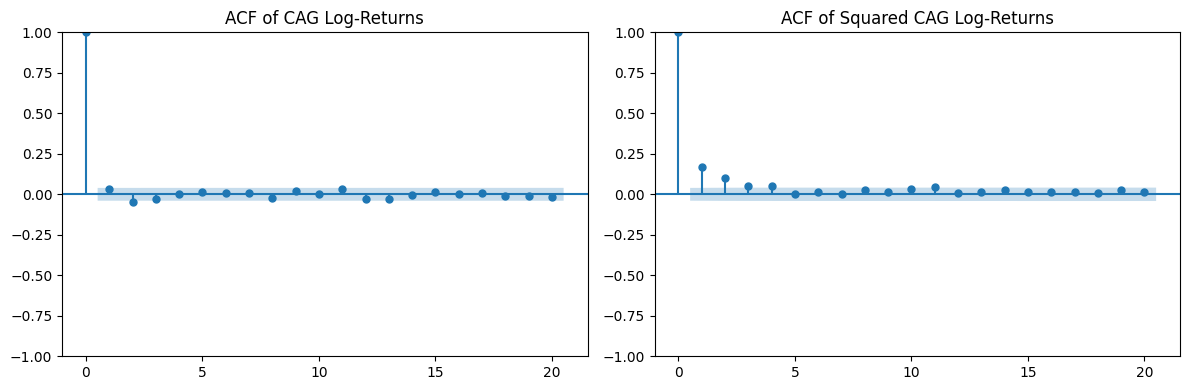

In [24]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_acf(cag['Log_Return'], lags=20, ax=plt.gca())
plt.title('ACF of CAG Log-Returns')
plt.subplot(1, 2, 2)
plot_acf(cag['Log_Return']**2, lags=20, ax=plt.gca())
plt.title('ACF of Squared CAG Log-Returns')
plt.tight_layout()
plt.show()

In [25]:
# Fit GARCH(1,1) model
cag_garch = arch_model(cag['Log_Return'], vol='Garch', p=1, q=1, mean='zero', rescale=True)
cag_garch_fit = cag_garch.fit(disp='off')
print(cag_garch_fit.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4546.46
Distribution:                  Normal   AIC:                           9098.92
Method:            Maximum Likelihood   BIC:                           9116.34
                                        No. Observations:                 2455
Date:                Sat, Mar 15 2025   Df Residuals:                     2455
Time:                        16:40:16   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0192  1.402e-02      1.366      0.172 

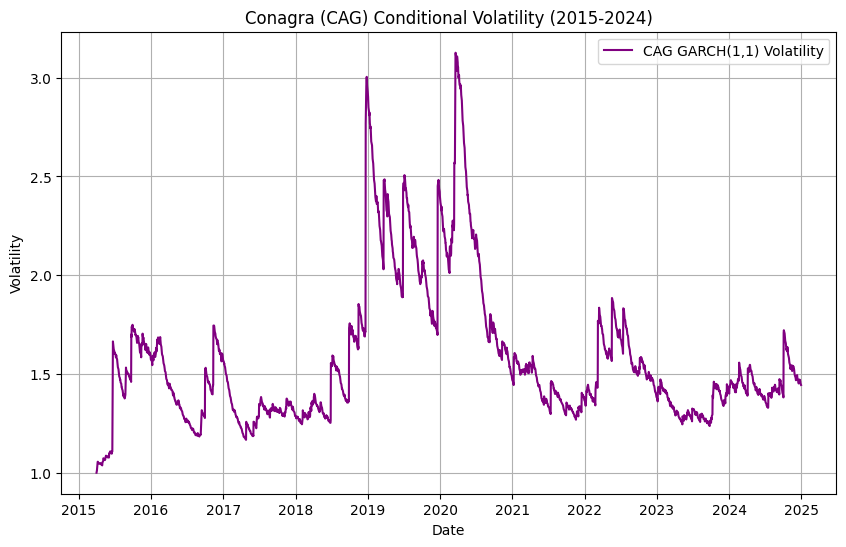

In [26]:
# Extract and plot conditional volatility
cag_volatility = cag_garch_fit.conditional_volatility
plt.figure(figsize=(10, 6))
plt.plot(cag_volatility, label='CAG GARCH(1,1) Volatility', color='purple')
plt.title('Conagra (CAG) Conditional Volatility (2015-2024)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
from scipy.stats import norm
cag_vol_forecast = (cag_garch_fit.forecast(horizon=1).variance.iloc[-1] ** 0.5)
cag_VaR_95 = norm.ppf(0.01) * cag_vol_forecast
cag_ES_95 = - (norm.pdf(norm.ppf(0.05)) / 0.05) * cag_vol_forecast
print(f"CAG VaR (99%): {cag_VaR_95}")
print(f"CAG ES (95%): {cag_ES_95}")

CAG VaR (99%): h.1   -3.343381
Name: 2024-12-30 00:00:00, dtype: float64
CAG ES (95%): h.1   -2.96449
Name: 2024-12-30 00:00:00, dtype: float64
